## Deisgn steel beam according to Eurocode 3
simply supported beam subjected to UDL

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Inputs 
# Loading
DL = 30  # kN/m
LL = 20   # kN/m
L  = 7   # m
fy = 275
# steel section profiles ('IPE', 'HEA', 'HEB', 'HEM', 'UB', 'UC', 'UBP', 'ALL')
section = 'IPE'

In [3]:
# import steel Section data
df = pd.read_csv('DB.csv')

# function to get Cat.
def filter_df(data, cat):
    if cat in data.Cat.unique():
        new_df = data.loc[data.Cat==cat]
        new_df.reset_index(inplace=True)
    else:
        new_df = data
    return new_df

temp_df = filter_df(df, section)

### Load Analysis
function that return the maximum shear force and bending moment of simply supported beam subjected to UDL load

In [4]:
# Load analysis
def udl_analysis(dead_load, live_load, length, plot=False):
    f_udl = 1.35 * dead_load + 1.5 * live_load  # Factored UDL
    Mu = f_udl * length ** 2 / 8  # Design Bending Moment
    Vu = f_udl * length / 2  # Design Shear force
    
    # Plot SFD and BMD
    x = np.linspace(0, length, 20)  # Generate x values for plotting
    M = f_udl * x ** 2 / 2 - Vu * x  # Calculate Bending Moment (M) at each x
    V = Vu - f_udl * x  # Calculate Shear Force (V) at each x
    
    # Extend x, V, and M arrays to include start and end points for proper visualization
    x = np.insert(x, [0, -1], [0, length])
    V = np.insert(V, [0, len(V)], 0)
    M = np.insert(M, [0, len(M)], 0)
    
    if plot == True:
        # Create subplots for SFD and BMD
        fig, axs = plt.subplots(2, 1)
        
        # Plot Shear Force Diagram (SFD)
        axs[0].plot(x, V, 'k--')  # Plot V against x
        axs[0].hlines(0, 0, length, 'k', '--')  # Draw horizontal line at y=0
        [axs[0].fill_between(x, V, 0, where=i, interpolate=True, color=j,
                             alpha=0.4, hatch='/////') for i, j in zip([(V > 0), (V < 0)], ['green', 'red'])]
        # Fill positive and negative regions of the SFD with different colors
        
        # Plot Bending Moment Diagram (BMD)
        axs[1].plot(x, M, 'k--')  # Plot M against x
        axs[1].hlines(0, 0, length, 'k', '--')  # Draw horizontal line at y=0
        axs[1].fill_between(x, M, 0, color='green', alpha=0.4, hatch='/////')
        # Fill the area under the BMD with green color
        
        # Set titles for the subplots
        axs[0].set_title(f'Shear Force Diagram (Vu = {Vu} kN)')
        axs[1].set_title(f'Bending Moment Diagram (Mu = {round(Mu, 2)} kNm)')
        
        fig.tight_layout()  # Adjust the spacing between subplots
        plt.show()  # Show the plot
        return fig
    
    return Vu, Mu
 

### Design functions
Section Classification (Table 5.2)\
Moment design (BS EN 1993-1-1:2005, 6.2.5)\
Shear Design (BS EN 1993-1-1:2005 6.2.6)\
Deflection (BS EN 1993-1-1 NA 2.23)

In [5]:
# Section Classification
def web_class(c, t, fy):
    # EN 1993-1-1:2005, Table:5.2
    eps = np.sqrt(235/fy)
    if c/t<= 72*eps:
        web_c = 1
    elif c/t < 83*eps:
        web_c = 2
    elif c/t < 124*eps:
        web_c = 3
    return web_c
def flange_class(c, t, fy):
    eps = np.sqrt(235/fy)
    if c/t<= 9*eps:
        flange_c = 1
    elif c/t < 10*eps:
        flange_c = 2
    elif c/t < 14*eps:
        flange_c = 3
    return flange_c

def Design(data, i, Med, Ved, fy, live_load, length, print_design=False):
    cw = data.h[i] - 2*data.tf[i] - 2*data.r[i]
    tw = data.tw[i]
    cf = (data.b[i] - data.tw[i])/2 - data.r[i]
    tf = data.tf[i]
    section_class = max(web_class(cw, tw, fy), flange_class(cf, tf, fy))
    
    # Bending Moment 
    Mcrd = data.Wply[i] * fy if section_class<=2 else data.Wely[i] * fy
    M_check = 'ok' if Med*10**6/Mcrd<=1 else 'fail'
    
    # Check Shear
    Av = max(data.A[i]-2*data.b[i]*data.tf[i] + (data.tw[i]+2*data.r[i])*data.tf[i],
        (data.h[i]-2*data.tf[i])*data.tw[i])
    Vcrd = Av*fy/np.sqrt(3)
    V_check = 'ok' if (Ved*10**3/Vcrd<=1) else 'fail'
    # Check Shear buckling
    hw = data.h[i]-2*data.tf[i]
    Sb_check = 'ok' if hw/data.tw[i] <=72*235/np.sqrt(fy) else 'fail'
    # check deflection
    w = 5*live_load*(length*1000)**4/(384*210000*data.Iy[i])
    Def_check = 'ok' if w <= length*1000/360 else 'fail'
    # overall design check
    design_check = 'ok' if (M_check=='ok')&(V_check=='ok')&(Sb_check=='ok')&(Def_check=='ok') else 'fail'
    if print_design == True:
        print(f'Result: \n'\
              f'Section is {data.Profile[i]}\n'\
              f'Section class = {section_class}\n'
              f'Mass of section = {data.m[i]} kg/m\n'\
              f'Med = {Med} kNm, Mcrd = {round(Mcrd/10**6, 2)} kNm\n'\
              f'Med/Mcrd = {round(Med/(Mcrd/10**6),2)}, \t---->\t {M_check}\n'\
              f'Ved = {Ved} kN, Vcrd = {round(Vcrd/10**3,2)} kN\n'\
              f'Ved/Vcrd = {round(Ved/(Vcrd/10**3),2)}, \t----> {V_check}\n'\
              f'deflection = {round(w,3)} mm, allowable deflection = {round(length*1000/360, 3)} mm, \t----> {Def_check}'
             )
        return 
    m = data.m[i]
    return design_check, m

In [6]:

Vu, Mu = udl_analysis(DL,LL,L)
mass = df.m.max()
row = 0
for i in range(len(temp_df)):
    design_check, m = Design(temp_df, i, Mu, Vu, fy, LL, L, print_design=False)
    if (design_check == 'ok') and (m < mass):
        row = i
        mass = m



## Result

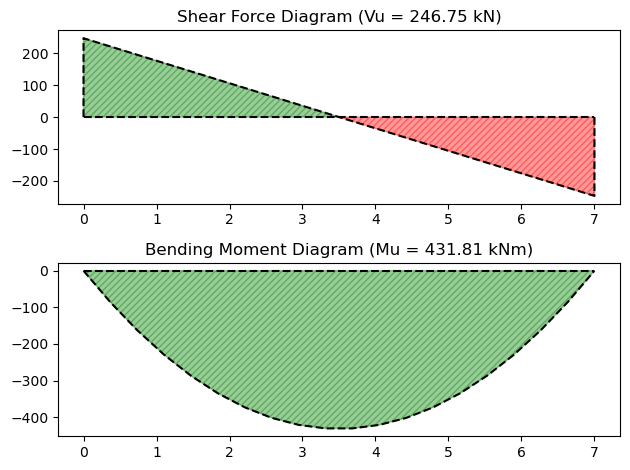

Result: 
Section is IPE450
Section class = 1
Mass of section = 77.6 kg/m
Med = 431.8125 kNm, Mcrd = 468.05 kNm
Med/Mcrd = 0.92, 	---->	 ok
Ved = 246.75 kN, Vcrd = 807.26 kN
Ved/Vcrd = 0.31, 	----> ok
deflection = 8.825 mm, allowable deflection = 19.444 mm, 	----> ok


In [7]:
fig = udl_analysis(DL,LL,L, plot=True)
Design(temp_df, row, Mu, Vu, fy, LL, L, print_design=True)